# Load Packages

In [99]:
import pandas as pd 
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import math
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Load and Preprocess Data

In [2]:
loan_df = pd.read_csv('loan.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Select relevant columns
columns_needed = ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'annual_inc',
                 'issue_d', 'dti', 'revol_bal', 'total_pymnt', 'loan_status']
df = loan_df[columns_needed]

# Part 1: Data Exploration and Evaluation

- annual income, dti, and revolving balance are right skewed and have outliers on the higher end of the spectrum - see distribution table and histograms below. These are handled by using log transformations in section 1.2
- loan funded amount and loan amount have 99% correlation - see correlation table below. This is handled using a ratio transformation in section 1.2 
- better grade loans reflect higher annual income of borrower, and correspond to a lower interest rate of loan - see aggregation by grade below
- there has been an exponential growth of loan originations - see histogram of loan origination dates in section 1.3
- 36 month term loans have a higher likelihood of being paid off. 27% of 36 month loans are fully paid, whereas 15% of 60 month loans are fully paid - see term table in section 1.3 

## 1.1 Initial data exploration

In [4]:
df.dtypes

loan_amnt      float64
funded_amnt    float64
term            object
int_rate       float64
grade           object
annual_inc     float64
issue_d         object
dti            float64
revol_bal      float64
total_pymnt    float64
loan_status     object
dtype: object

In [5]:
df.isnull().sum()
# there are 4 missing values for annual income - impute missing values in section 1.2

loan_amnt      0
funded_amnt    0
term           0
int_rate       0
grade          0
annual_inc     4
issue_d        0
dti            0
revol_bal      0
total_pymnt    0
loan_status    0
dtype: int64

In [6]:
# table of loan issue origination years
df['issue_d'].str[-4:].value_counts()
# most loan data is from 2015 - probably reflects growing popularity of lending club

2015    421094
2014    235628
2013    134755
2012     53367
2011     21721
2010     12537
2009      5281
2008      2393
2007       603
Name: issue_d, dtype: int64

In [7]:
df['issue_d'].str[:3].value_counts()
# seasonality

Oct    111971
Jul     95499
Nov     88081
Dec     80420
Aug     76522
Apr     70214
May     67929
Jun     63874
Jan     62825
Sep     62194
Mar     56102
Feb     51748
Name: issue_d, dtype: int64

In [9]:
# Summary statistics of numeric values
df_num_summary = df.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T
df_num_summary['p_nan'] = (df.shape[0] - df_num_summary['count'])/df.shape[0]
df_num_summary
# annual income is highly skewed - outlier on high end - outliers handled in section 1.2 
# dti and revol_bal also have outliers on high end

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max,p_nan
loan_amnt,887379.0,14755.264605,8435.455601,500.00,1800.00,3600.000,5000.00,8000.00,13000.000000,20000.000000,28000.00,32000.00,35000.0000,3.500000e+04,0.000000
funded_amnt,887379.0,14741.877625,8429.897657,500.00,1800.00,3600.000,5000.00,8000.00,13000.000000,20000.000000,27975.00,32000.00,35000.0000,3.500000e+04,0.000000
int_rate,887379.0,13.246740,4.381867,5.32,5.32,6.620,7.69,9.99,12.990000,16.200000,18.99,20.99,24.9900,2.899000e+01,0.000000
annual_inc,887375.0,75027.587761,64698.300142,0.00,19000.00,28000.000,34000.00,45000.00,65000.000000,90000.000000,124800.00,150000.00,250000.0000,9.500000e+06,0.000005
dti,887379.0,18.157039,17.190626,0.00,1.98,5.200,7.45,11.91,17.650000,23.950000,29.57,32.72,37.4800,9.999000e+03,0.000000
revol_bal,887379.0,16920.787533,22426.791896,0.00,309.00,2031.000,3418.80,6443.00,11875.000000,20829.000000,33478.00,43897.00,93410.6600,2.904836e+06,0.000000
total_pymnt,887379.0,7558.826684,7871.243336,0.00,0.00,343.825,690.15,1914.59,4894.999117,10616.814231,18254.58,24020.30,36594.8014,5.777758e+04,0.000000


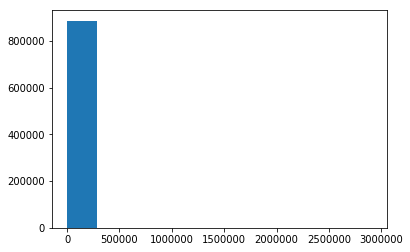

In [10]:
# histogram of revolbing balance
plt.hist(df['revol_bal'])
plt.show()

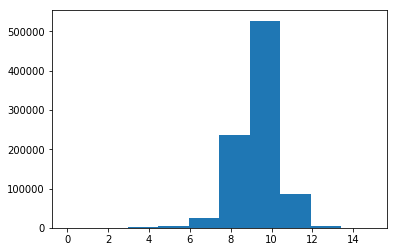

In [11]:
# histogram of log transformation of revolving balance
plt.hist(np.log(df.loc[df['revol_bal'] != 0, 'revol_bal']))
plt.show()
# do log transformation in section 1.2

In [12]:
print('Loans funded for their original applied amount')
print(pd.Series(df['loan_amnt'] == df['funded_amnt']).value_counts())
print('Loans funded for a lower amount than what the applicant applied for')
print(pd.Series(df['loan_amnt'] > df['funded_amnt']).value_counts())
# less than 1% of loans were funded for a lower amount than what they applied for

Loans funded for their original applied amount
True     885317
False      2062
dtype: int64
Loans funded for a lower amount than what the applicant applied for
False    885317
True       2062
dtype: int64


In [13]:
df['loan_status'].value_counts()
# two of these categories: 1. Does not meet the credit policy. Status:Fully Paid and Does not meet the credit policy. Status:Charged Off
# are redundant for Fully Paid and Charged off - change this below in section 1.2

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [14]:
# df['loan_status'] = df['loan_status'].str.replace('Does not meet the credit policy. Status:','')
# df['loan_status'].value_counts()

In [15]:
df['term'].value_counts()

 36 months    621125
 60 months    266254
Name: term, dtype: int64

In [87]:
# 70% of loans have a term of 36 months
df[df['term'] == ' 36 months'].shape[0]/df.shape[0]

0.699954585357553

In [16]:
df['grade'].value_counts()

B    254535
C    245860
A    148202
D    139542
E     70705
F     23046
G      5489
Name: grade, dtype: int64

In [81]:
metrics = ['mean', 'median']
df.groupby('grade').agg({'annual_inc': metrics, 
                        'revol_bal': metrics, 
                        'int_rate': metrics,
                        'dti': metrics})
# better grade loans are correlated with higher annual income, and lower interest rates

annual_inc              revol_bal            int_rate         \
               mean   median          mean   median       mean median   
grade                                                                   
A      86942.651653  75000.0  18953.963199  12866.0   7.243312   7.26   
B      75487.389207  65000.0  16911.403017  11879.0  10.829618  10.99   
C      71536.950300  60000.0  16355.232405  11563.0  13.980098  13.99   
D      69169.272616  60000.0  15880.873551  11304.0  17.175814  16.99   
E      72119.152229  61000.0  16847.066077  12155.0  19.897322  19.99   
F      73801.170917  65000.0  16410.247158  12022.5  23.582787  23.76   
G      79904.591762  68000.0  17322.579705  11553.0  25.626706  25.83   

             dti          
            mean  median  
grade                     
A      15.577401  15.080  
B      17.305115  16.860  
C      18.792559  18.350  
D      19.908175  19.450  
E      20.338847  20.050  
F      19.834316  19.695  
G      19.182093  19.280

In [17]:
df.corr()
# loan amount is highly correlated with funded amount - as one would expect - remove correlation in section 1.2

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt
loan_amnt,1.000000,0.999263,0.145023,0.332698,0.020675,0.333580,0.474626
funded_amnt,0.999263,1.000000,0.145160,0.332466,0.021075,0.333435,0.473286
int_rate,0.145023,0.145160,1.000000,-0.072786,0.079903,-0.035708,0.170506
annual_inc,0.332698,0.332466,-0.072786,1.000000,-0.087410,0.295784,0.160879
dti,0.020675,0.021075,0.079903,-0.087410,1.000000,0.067277,-0.041529
revol_bal,0.333580,0.333435,-0.035708,0.295784,0.067277,1.000000,0.138328
total_pymnt,0.474626,0.473286,0.170506,0.160879,-0.041529,0.138328,1.000000


In [82]:
pd.crosstab(df['term'], df['loan_status'])

loan_status,Charged Off,Current,Default,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
term,,,,,,,,
36 months,29732,402848,715,169364,3975,5982,1483,7026
60 months,16277,198931,504,40347,2278,2478,874,4565


## 1.2 Clean data and handle missing values 
- issue_d: change to datetime field and create year and month variable
- loan_status: change categorical values with redundant prefix
- annual_inc: impute values for missing values and self reported 0 annual income, log transformation to handle outliers
- monthly_debt_payments: calculate monthly debt payments from self reported income and dti, log transformation to handle outliers
- revol_bal: log transformation to handle outliers
- dti: log transformation to handle outliers
- funded_amnt: remove correlation with loan_amnt by ratio transformation
- assumption: when doing log transformations, log of 0 is undefined - so the median of the log transformation within each cohort is imputed. A cohort is defined as a grade in a given year. Assume that this imputation will add minimal noise. Also assume that the distributions of the model training set is the same as the distribution of the entire population

### issue_d

In [18]:
# create year variable
df['year'] = df['issue_d'].str[-4:]
df['month'] = df['issue_d'].str[:3]
# change to date - since there is no day, assumes that month-year is the first day of the month
df['issue_d'] = pd.to_datetime(df['issue_d'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

### loan_status

In [19]:
df['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [20]:
df['loan_status'] = df['loan_status'].str.replace('Does not meet the credit policy. Status:','')
df['loan_status'].value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Current               601779
Fully Paid            209711
Charged Off            46009
Late (31-120 days)     11591
Issued                  8460
In Grace Period         6253
Late (16-30 days)       2357
Default                 1219
Name: loan_status, dtype: int64

### annual_inc

In [21]:
df[(df['annual_inc'].isnull())]
# all of the null annual incomes are grade A in 2007 - replace with median income of grade A in 2017

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status,year,month
42449,5000.0,5000.0,36 months,7.43,A,NaN,2007-08-01,1.0,0.0,5593.46,Fully Paid,2007,Aug
42450,7000.0,7000.0,36 months,7.75,A,NaN,2007-08-01,1.0,0.0,7867.53,Fully Paid,2007,Aug
42480,6700.0,6700.0,36 months,7.75,A,NaN,2007-07-01,1.0,0.0,7530.42,Fully Paid,2007,Jul
42533,6500.0,6500.0,36 months,8.38,A,NaN,2007-06-01,4.0,0.0,7373.83,Fully Paid,2007,Jun


In [22]:
# get average and median income by grade and year - in 
inc_table = df.groupby(['grade', 'year']).agg({'annual_inc': ['mean', 'min', 'max', 'median', 'count']})
inc_table.columns = ['_'.join(x) for x in inc_table.columns.ravel()]
inc_table = inc_table.reset_index()
inc_table
# median income of grade A in 2007 is 70000

,grade,year,annual_inc_mean,annual_inc_min,annual_inc_max,annual_inc_median,annual_inc_count
0,A,2007,83171.972973,6500.0,300000.00,70000.00,74
1,A,2008,57790.541761,3300.0,522000.00,48000.00,318
2,A,2009,69816.756068,5500.0,1440000.00,55000.00,1203
3,A,2010,66501.631919,8004.0,1900000.00,58589.36,2830
4,A,2011,66476.629960,6000.0,1200000.00,58604.00,5754
5,A,2012,70755.874434,6695.0,1250000.00,60000.00,10901
6,A,2013,89060.558096,8500.0,2000000.00,80000.00,17675
7,A,2014,87609.027640,6000.0,7446395.00,75000.00,36108
8,A,2015,91315.979344,7000.0,9500000.00,77000.00,73335
9,B,2007,67050.305204,2000.0,616000.00,54999.50,98


In [23]:
# replace null annual income with median of the grade and year 
df["annual_inc_2"] = df.groupby(['grade', 'year'])['annual_inc'].transform(lambda x: x.fillna(x.median()))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
# # log transform where income is not equal to 0 then replace null value with median log on grade and year cohort
# df.loc[df['annual_inc_2'] !=0, 'annual_inc_log'] = np.log(df.loc[df['annual_inc_2'] !=0, 'annual_inc_2'])
# df["annual_inc_log"] = df.groupby(['grade', 'year'])['annual_inc_log'].transform(lambda x: x.fillna(x.median()))
# df['annual_inc_log'].describe()

In [25]:
# # before log transformation
# plt.hist(df['annual_inc_2'])
# plt.show()

In [26]:
# # after log transformation
# plt.hist(df['annual_inc_log'])
# plt.show()

### monthly_debt_payments

In [27]:
df['monthly_inc'] = df['annual_inc_2']/12
df['monthly_debt_payments'] = df['monthly_inc'] * df['dti']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


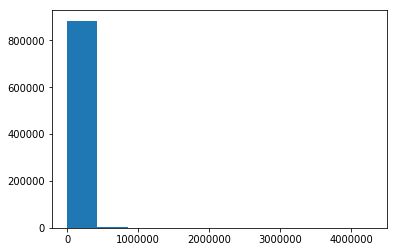

In [28]:
plt.hist(df['monthly_debt_payments'])
plt.show()

In [29]:
# # log transform where income is not equal to 0 then replace null value with median log on grade and year cohort
# df.loc[df['monthly_debt_payments'] !=0, 'monthly_debt_payments_log'] = np.log(df.loc[df['monthly_debt_payments'] !=0, 'monthly_debt_payments'])
# df["monthly_debt_payments_log"] = df.groupby(['grade', 'year'])['monthly_debt_payments_log'].transform(lambda x: x.fillna(x.median()))
# plt.hist(df['monthly_debt_payments_log'])
# plt.show()

### log transformations
- annual_inc
- monthly_debt_payments
- dti
- revol_bal

In [30]:
def log_transform(col_name, df): 
    # create _log variable where variable is not equal to 0
    df.loc[df[col_name] !=0, col_name + '_log'] = np.log(df.loc[df[col_name] !=0, col_name])
    # impute missing value of log variable (where original variable = 0) with median of grade/year cohort
    df[col_name + '_log'] = df.groupby(['grade', 'year'])[col_name + '_log'].transform(lambda x: x.fillna(x.median()))
    return df

In [31]:
log_transform_columns = ['annual_inc_2', 'monthly_debt_payments', 'dti', 'revol_bal']
for column in log_transform_columns: 
    df = log_transform(column, df)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [32]:
df.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status,year,month,annual_inc_2,monthly_inc,monthly_debt_payments,annual_inc_2_log,monthly_debt_payments_log,dti_log,revol_bal_log
0,5000.0,5000.0,36 months,10.65,B,24000.0,2011-12-01,27.65,13648.0,5861.071414,Fully Paid,2011,Dec,24000.0,2000.000000,55300.00,10.085809,10.920528,3.319626,9.521348
1,2500.0,2500.0,60 months,15.27,C,30000.0,2011-12-01,1.00,1687.0,1008.710000,Charged Off,2011,Dec,30000.0,2500.000000,2500.00,10.308953,7.824046,0.000000,7.430707
2,2400.0,2400.0,36 months,15.96,C,12252.0,2011-12-01,8.72,2956.0,3003.653644,Fully Paid,2011,Dec,12252.0,1021.000000,8903.12,9.413444,9.094157,2.165619,7.991592
3,10000.0,10000.0,36 months,13.49,C,49200.0,2011-12-01,20.00,5598.0,12226.302212,Fully Paid,2011,Dec,49200.0,4100.000000,82000.00,10.803649,11.314475,2.995732,8.630165
4,3000.0,3000.0,60 months,12.69,B,80000.0,2011-12-01,17.94,27783.0,3242.170000,Current,2011,Dec,80000.0,6666.666667,119600.00,11.289782,11.691908,2.887033,10.232180


### funded_amnt

In [33]:
df['p_loan_funded'] = df['funded_amnt']/df['loan_amnt']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## 1.3 More exploratory analysis

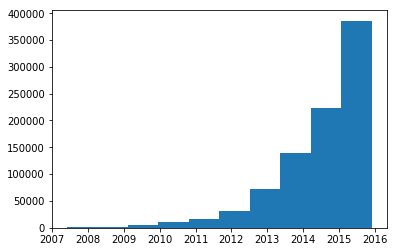

In [89]:
plt.hist(df['issue_d'])
plt.show()
# exponential growth of loan originations - corresponds to growing popularity of lending platform

In [95]:
term = pd.crosstab(df['loan_status'], df['term'])
term = term.reset_index()
term['36_m_p'] = term[' 36 months']/term[' 36 months'].sum()
term['60_m_p'] = term[' 60 months']/term[' 60 months'].sum()
term
# 27% of 36 month loans are fully paid, whereas 15% of 60 month loans are fully paid.

term,loan_status,36 months,60 months,36_m_p,60_m_p
0,Charged Off,29732,16277,0.047868,0.061133
1,Current,402848,198931,0.648578,0.747147
2,Default,715,504,0.001151,0.001893
3,Fully Paid,169364,40347,0.272673,0.151536
4,In Grace Period,3975,2278,0.006400,0.008556
5,Issued,5982,2478,0.009631,0.009307
6,Late (16-30 days),1483,874,0.002388,0.003283
7,Late (31-120 days),7026,4565,0.011312,0.017145


# Part 2: Business Analysis

In [34]:
# exclude loans with less than 36 months of data available
# most recent data is December 2015 - so only loans originating on or before January 2013 have 36 months of data available 
df36 = df [df['issue_d'] <= pd.to_datetime('Jan-2013')]

In [35]:
pd.crosstab(df36['loan_status'], df36['term'])

term,36 months,60 months
loan_status,,
Charged Off,10372,4955
Current,735,5936
Default,21,27
Fully Paid,69225,10943
In Grace Period,49,118
Late (16-30 days),19,38
Late (31-120 days),120,216


## 2.1 What percentage of loans have been fully paid? 

78%

In [36]:
df36_status = df36.groupby('loan_status').agg({'loan_status':'count'})
df36_status = df36_status.rename(columns={'loan_status': 'count'})
df36_status = df36_status.reset_index()
df36_status['percent'] = df36_status['count']/df36.shape[0]
df36_status
# 78% of loans are fully paid

,loan_status,count,percent
0,Charged Off,15327,0.149133
1,Current,6671,0.064909
2,Default,48,0.000467
3,Fully Paid,80168,0.780042
4,In Grace Period,167,0.001625
5,Late (16-30 days),57,0.000555
6,Late (31-120 days),336,0.003269


## 2.2 What cohort has the highest rate of defaults? 

Grade G loans originated in 2013

In [37]:
# defaulted loans are loans that are not fully paid
df36['default'] = np.where(df36['loan_status'] != 'Fully Paid', 1, 0)
df36['default'].value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0    80168
1    22606
Name: default, dtype: int64

In [38]:
df36_status2 = df36.groupby(['year', 'grade']).agg({'default': ['sum', 'count']})
df36_status2.columns = ['_'.join(x) for x in df36_status2.columns.ravel()]
df36_status2 = df36_status2.rename(columns={'default_count': 'total'})
df36_status2 = df36_status2.reset_index()
df36_status2['percent_default'] = df36_status2['default_sum']/df36_status2['total']
# order by percent default 
df36_status2.sort_values('percent_default', ascending=False).head(10)
# grade G loans in 2013 have the highest rate of default

,year,grade,default_sum,total,percent_default
48,2013,G,11,14,0.785714
47,2013,F,91,139,0.654676
41,2012,G,160,261,0.613027
46,2013,E,205,351,0.584046
40,2012,F,752,1315,0.571863
39,2012,E,1666,3185,0.523077
33,2011,F,368,722,0.509695
34,2011,G,99,203,0.487685
6,2007,G,17,35,0.485714
5,2007,F,25,52,0.480769


## 2.3 What annualized rate of return have these loans generated? 

Loans of grade G originated in 2013 have an average annualized rate of return of -10.4%

In [39]:
df36['arr'] = (df36['total_pymnt'] / df36['funded_amnt']) ** (1/3) - 1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [40]:
df36.arr.describe()

count    102774.000000
mean          0.015552
std           0.115683
min          -1.000000
25%           0.024101
50%           0.045853
75%           0.067103
max           0.190869
Name: arr, dtype: float64

In [41]:
df36_status3 = df36.groupby(['year', 'grade']).agg({'default': ['sum', 'count'], 
                                                   'arr': 'mean'})
df36_status3.columns = ['_'.join(x) for x in df36_status3.columns.ravel()]
df36_status3 = df36_status3.rename(columns={'default_count': 'total'})
df36_status3 = df36_status3.reset_index()
df36_status3['percent_default'] = df36_status3['default_sum']/df36_status3['total']
# order by percent default 
df36_status3.sort_values('percent_default', ascending=False).head(10)
# grade G loans in 2013 have the highest rate of default - these loans have an average annualized rate of return of -10.4%

,year,grade,default_sum,total,arr_mean,percent_default
48,2013,G,11,14,-0.104408,0.785714
47,2013,F,91,139,-0.026245,0.654676
41,2012,G,160,261,-0.015510,0.613027
46,2013,E,205,351,-0.011920,0.584046
40,2012,F,752,1315,-0.004124,0.571863
39,2012,E,1666,3185,-0.000143,0.523077
33,2011,F,368,722,0.014506,0.509695
34,2011,G,99,203,0.005108,0.487685
6,2007,G,17,35,-0.044102,0.485714
5,2007,F,25,52,-0.079863,0.480769


# Part 3: Modeling
- transform categorical variables to binary variables
- use random forest model for variable selection
- fit a logistic regression model on the top variables
- evaluation

In [42]:
data = df36.copy()
data = data.reset_index(drop=True)

In [43]:
# categorical variables: use dummy - could also use WOE transformations
catigorical_columns = ['grade', 'month']
for var in catigorical_columns:
    cat_list = 'var'+'_' + var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data = data.join(cat_list)

In [44]:
data.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,...,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,5000.0,5000.0,36 months,10.65,B,24000.0,2011-12-01,27.65,13648.0,5861.071414,...,1,0,0,0,0,0,0,0,0,0
1,2500.0,2500.0,60 months,15.27,C,30000.0,2011-12-01,1.00,1687.0,1008.710000,...,1,0,0,0,0,0,0,0,0,0
2,2400.0,2400.0,36 months,15.96,C,12252.0,2011-12-01,8.72,2956.0,3003.653644,...,1,0,0,0,0,0,0,0,0,0
3,10000.0,10000.0,36 months,13.49,C,49200.0,2011-12-01,20.00,5598.0,12226.302212,...,1,0,0,0,0,0,0,0,0,0
4,3000.0,3000.0,60 months,12.69,B,80000.0,2011-12-01,17.94,27783.0,3242.170000,...,1,0,0,0,0,0,0,0,0,0


## Variable selection - random forest model

In [45]:
# 70/30 split
np.random.seed(100)
ind = np.random.choice(data.shape[0], math.floor(data.shape[0]*0.7), replace=False).tolist()
train = data.iloc[ind, :]
test = data.iloc[~data.index.isin(ind), :]
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)
print(data.shape)
print(train.shape)
print(test.shape)

(102774, 42)
(71941, 42)
(30833, 42)


In [46]:
#split x and y
# make sure no target leaking variables - e.g. total payment or loan status, which is information that is not available at the time of loan review 
# also remove variables that underwent log transformations
feature_vars = [col for col in train.columns if col not in ['default', 'arr', 'funded_amnt', 'term', 
                                                           'issue_d', 'year', 'loan_status', 'grade', 
                                                           'annual_inc', 'month', 'total_pymnt', 
                                                           'revol_bal', 'dti', 'monthly_debt_payments', 
                                                           'monthly_inc', 'annual_inc_2']]
target_var = 'default'

copy_train = train.copy()
X_train = copy_train[feature_vars]
Y_train = copy_train[target_var]

copy_test = test.copy()
X_test = copy_test[feature_vars]
Y_test = copy_test[target_var]

In [47]:
#rf regression model
rf_model = RandomForestClassifier(random_state = 0, 
                                n_estimators = 500)

rf_model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [48]:
# feature importance dataframe from random forest model output
def create_feature_importance_df(model, train_df):
    #dictionary
    model_feature_importance = {}
    for feature, importance in zip(train_df.columns, model.feature_importances_): 
        model_feature_importance[feature] = importance
        
    model_feature_importance = pd.DataFrame.from_dict(model_feature_importance, orient = 'index')
    model_feature_importance.reset_index(level = 0, inplace = True)
    model_feature_importance = model_feature_importance.rename(columns = {'index': 'feature_variables', 
                                                                         0: 'feature_importance'})
    
    model_feature_importance = model_feature_importance.sort_values(by = 'feature_importance', ascending = False)
    model_feature_importance['cumul_feature_importance'] = model_feature_importance['feature_importance'].cumsum()
    
    return model_feature_importance.reset_index(drop = True)

In [53]:
rf_importance = create_feature_importance_df(rf_model, X_train)
rf_importance
# looking at the feature importance rankings, the variables below int_rate add very little incremental value 

,feature_variables,feature_importance,cumul_feature_importance
0,revol_bal_log,0.154879,0.154879
1,dti_log,0.150285,0.305164
2,monthly_debt_payments_log,0.149509,0.454673
3,loan_amnt,0.138326,0.593000
4,annual_inc_2_log,0.133845,0.726844
5,int_rate,0.129391,0.856235
6,grade_A,0.015639,0.871874
7,month_Nov,0.008955,0.880829
8,month_Dec,0.008833,0.889661
9,month_Jan,0.008463,0.898124


## Logistic regression model

In [55]:
important_variables = rf_importance['feature_variables'][:6]
important_variables

0                revol_bal_log
1                      dti_log
2    monthly_debt_payments_log
3                    loan_amnt
4             annual_inc_2_log
5                     int_rate
Name: feature_variables, dtype: object

In [56]:
X_train2 = copy_train[important_variables]
X_test2 = copy_test[important_variables]

In [57]:
logreg = LogisticRegression()
logreg.fit(X_train2,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Evaluation - gains table, ROC, and KS

In [70]:
# make a gains table and evaluate how the model ranks the actual delinquencies
val = pd.DataFrame({'predicted_' + target_var: logreg.predict_proba(X_test2)[:,1],
                   'actual_' + target_var: Y_test, 
                   'funded_amnt': copy_test['funded_amnt'], 
                   'total_pymnt': copy_test['total_pymnt']})
# calculate money lost on default for each loan - if it defulted, it is the funded amount minus the payed amount
val['loss_on_default'] = np.where(val['actual_' + target_var] == 1, val['funded_amnt'] - val['total_pymnt'], 0)
val['decile'] = pd.qcut(val['predicted_' + target_var].rank(method = 'first').values, 10).codes + 1
val = val.groupby('decile', as_index = False).agg({'actual_' + target_var: 'sum', 
                                            'predicted_' + target_var: [min, max, np.mean, 'count'], 
                                                  'loss_on_default': 'sum'})
val.columns = ['_'.join(x) if x != ('decile', '') else 'decile'for x in val.columns.ravel()]
val.columns = val.columns.str.replace(' ', '_')
val.sort_values(by = 'decile', ascending = False, inplace = True)
val.rename(columns = {'predicted_default_count': 'count'}, inplace = True)
val['loss_on_default_cum'] = val['loss_on_default_sum'].cumsum()
val['observed_percent_default'] = val['actual_default_sum']/val['count']
val['cum_percent_total'] = 100 * val['count'].cumsum()/val['count'].sum()
val['gain'] = 100 * val['actual_default_sum'].cumsum()/val['actual_default_sum'].sum()
val['diff'] = val['gain'] - val['cum_percent_total']
val['lift'] = val['gain']/val['cum_percent_total']
print('KS: ' + str(max(val['diff'])))
val = val.reset_index(drop=True)
val

KS: 22.650183436343468


,decile,actual_default_sum,predicted_default_min,predicted_default_max,predicted_default_mean,count,loss_on_default_sum,loss_on_default_cum,observed_percent_default,cum_percent_total,gain,diff,lift
0,10,1592,0.406001,0.743401,0.513746,3084,6.485085e+06,6.485085e+06,0.516213,10.002270,23.512037,13.509766,2.350670
1,9,1080,0.310464,0.405930,0.353410,3083,3.477989e+06,9.963074e+06,0.350308,20.001297,39.462413,19.461116,1.972993
2,8,884,0.255585,0.310408,0.280863,3083,2.955717e+06,1.291879e+07,0.286734,30.000324,52.518092,22.517768,1.750584
3,7,686,0.219254,0.255544,0.236310,3083,2.163814e+06,1.508261e+07,0.222511,39.999351,62.649535,22.650183,1.566264
4,6,612,0.190074,0.219232,0.204248,3083,1.948611e+06,1.703122e+07,0.198508,49.998378,71.688082,21.689703,1.433808
5,5,563,0.163020,0.190070,0.176432,3084,1.610100e+06,1.864132e+07,0.182555,60.000649,80.002954,20.002305,1.333368
6,4,457,0.135755,0.163015,0.149493,3083,1.144618e+06,1.978594e+07,0.148232,69.999676,86.752326,16.752650,1.239325
7,3,429,0.108518,0.135745,0.122345,3083,1.258126e+06,2.104406e+07,0.139150,79.998703,93.088170,13.089467,1.163621
8,2,289,0.082341,0.108517,0.095215,3083,7.542090e+05,2.179827e+07,0.093740,89.997730,97.356373,7.358643,1.081765
9,1,179,0.032718,0.082340,0.068263,3084,4.573897e+05,2.225566e+07,0.058042,100.000000,100.000000,0.000000,1.000000


In [59]:
# auc
roc_auc_score(Y_test, logreg.predict_proba(X_test2)[:,1])

0.7043242828325353

In [75]:
# val['loss_on_default_cum'][1]/val['loss_on_default_cum'][9]

0.4476647373042471

In [102]:
Y_pred = logreg.predict(X_test2)
print("Accuracy:", metrics.accuracy_score(Y_test, Y_pred))
print("Precision:", metrics.precision_score(Y_test, Y_pred))
print("Recall:", metrics.recall_score(Y_test, Y_pred))
# with a cutoff of 50% 

Accuracy: 0.7876301365420166
Precision: 0.5731147540983607
Recall: 0.12907989957170285


The logistic regression model identifies 39% of defaulters within the first two deciles of the testing population - this corresponds to identifying 44.7% of all loan losses from defaults (~$10M). This is a lift of 2x better than random selection of defaulted loans.

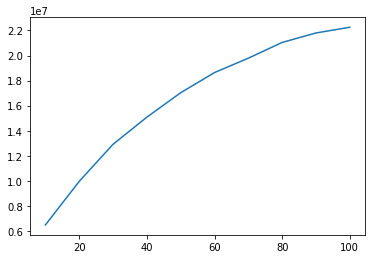

In [66]:
plt.plot(val['cum_percent_total'], val['loss_on_default_cum'])
plt.show()

## Model evaluation
- The model is somewhat effective at identifying defaulting loans. 
- A 30% in-time testing sample was held out from the training population and this testing sample was used to evaluate the model.
- Applying this model to the testing sample results in a KS of 22.6% and an ROC of 70%
- The gains table indicates that this model is good at ranking defaults and prioritizing defaults -  
- When there is a 50% threshold for default for probability of default (> 50% - default classification and < 50% non default classification), the model has a precision of 57% and recall of 13%. This means that 57% of the loans identified as default will actually default and 13% of all defaults are actually captured in the model. This means that a substantially large amount (87%) of the defaults are missed in default classification and there is also a 43% chance of turning away a good loan. 
- In order to find an optimal precision/recall and false negative/positive rate, the threshold of default classification would have to be changed
- Although the presision and recall scores are low, the model identifies 39% of defaulters within the first two deciles of the testing population This is a lift of 2x better than random selection (see gains table) and it corresponds to identifying 44.7% of all loan losses from defaults (~$10M). This means that the model is good at prioritizing high loan losses 

- In order to refine this model and improve its performance: 
> - Current 60 month loans add noise to the target variable and they should not be treated as 36 month loans
> - Delinquent loans (late, grace period) should not be treated as default loans because they have not defaulted yet. This adds noise to the model and assumes that all loans that are currently delinquent or have been delinquent will result in a loss
> - Use a FICO score or similar credit scoring to replace the grade, which is a bucketed version of a score
> - Use client's cross-product data: e.g. payment history from other loans
> - Use random forest algorithm instead of logistic regression to yield better performance